DEEP EDA: DISCOVERING WHAT ACTUALLY PREDICTS 2025

Total receivals: 122383
Date range: 2004-06-15 to 2024-12-19

[1] UNDERSTANDING THE 2025 PREDICTION TASK
--------------------------------------------------------------------------------
Unique rm_ids in test set: 203
Test rm_ids with 2024 data: 60 (29.6%)
Test rm_ids with NO 2024 data: 143

Sample last deliveries for rm_ids WITHOUT 2024 data:
  Min: 2004-09-03
  Max: 2005-03-30
  ⚠️ These are COLD rm_ids - probably should predict ZERO!

[2] ANALYZING 2025 TEST SET STRUCTURE
--------------------------------------------------------------------------------
Total predictions needed: 30450

Horizon distribution:
horizon_days
2      203
3      203
4      203
5      203
6      203
7      203
8      203
9      203
10     203
11     203
12     203
13     203
14     203
15     203
16     203
17     203
18     203
19     203
20     203
21     203
22     203
23     203
24     203
25     203
26     203
27     203
28     203
29     203
30     203
31

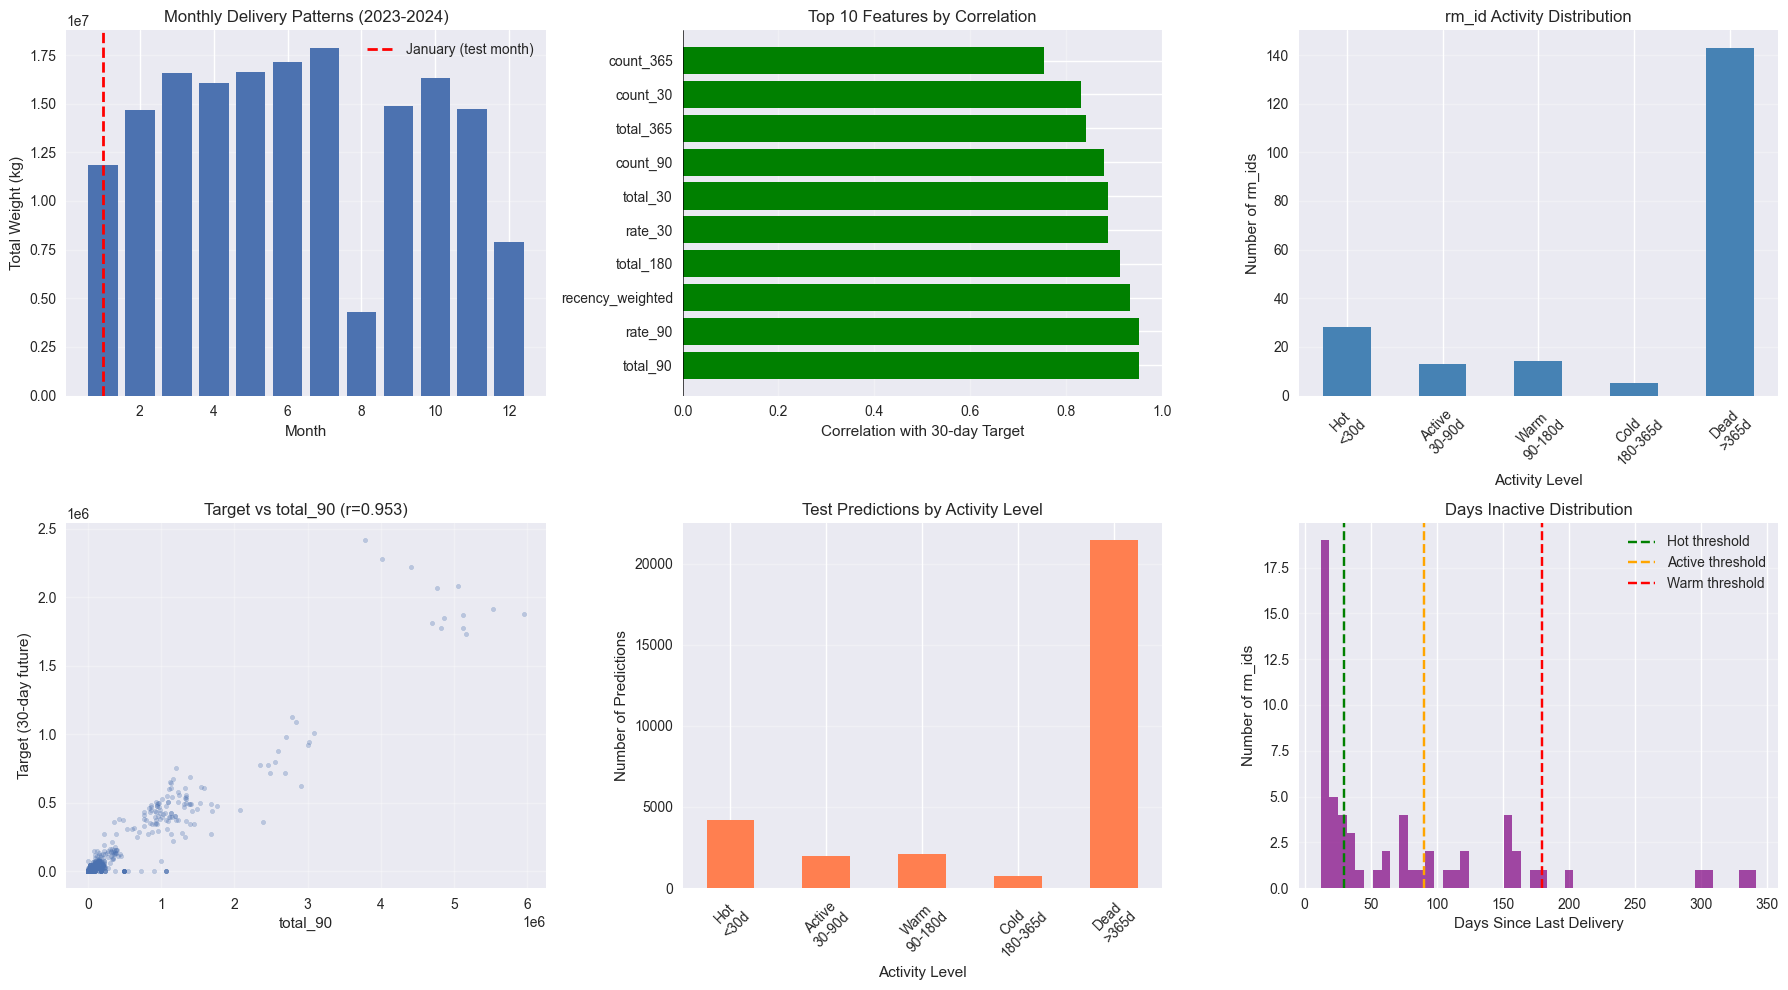

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from scipy import stats

plt.style.use('seaborn-v0_8')

# Load data
receivals = pd.read_csv('./Project_materials/data/kernel/receivals.csv')
purchase_orders = pd.read_csv('./Project_materials/data/kernel/purchase_orders.csv')
prediction_mapping = pd.read_csv('./Project_materials/data/prediction_mapping.csv')

# Convert dates
receivals['date_arrival'] = pd.to_datetime(receivals['date_arrival'], utc=True).dt.tz_localize(None)
purchase_orders['delivery_date'] = pd.to_datetime(purchase_orders['delivery_date'], utc=True).dt.tz_localize(None)
purchase_orders['created_date_time'] = pd.to_datetime(purchase_orders['created_date_time'], utc=True).dt.tz_localize(None)
prediction_mapping['forecast_start_date'] = pd.to_datetime(prediction_mapping['forecast_start_date'])
prediction_mapping['forecast_end_date'] = pd.to_datetime(prediction_mapping['forecast_end_date'])

print("="*80)
print("DEEP EDA: DISCOVERING WHAT ACTUALLY PREDICTS 2025")
print("="*80)

# Clean data
receivals = receivals[receivals['net_weight'] > 0]
receivals = receivals[receivals['rm_id'].notna()]
receivals = receivals.sort_values('date_arrival')

print(f"\nTotal receivals: {len(receivals)}")
print(f"Date range: {receivals['date_arrival'].min().date()} to {receivals['date_arrival'].max().date()}")

# ============================================================================
# QUESTION 1: What rm_ids are we actually predicting for in 2025?
# ============================================================================
print("\n[1] UNDERSTANDING THE 2025 PREDICTION TASK")
print("-"*80)

test_rm_ids = prediction_mapping['rm_id'].unique()
print(f"Unique rm_ids in test set: {len(test_rm_ids)}")

# Check how many have ANY 2024 data
rm_ids_with_2024_data = receivals[receivals['date_arrival'] >= '2024-01-01']['rm_id'].unique()
test_rm_with_2024 = [rm for rm in test_rm_ids if rm in rm_ids_with_2024_data]

print(f"Test rm_ids with 2024 data: {len(test_rm_with_2024)} ({len(test_rm_with_2024)/len(test_rm_ids)*100:.1f}%)")
print(f"Test rm_ids with NO 2024 data: {len(test_rm_ids) - len(test_rm_with_2024)}")

# For rm_ids with no 2024 data, what's their last delivery?
test_rm_without_2024 = [rm for rm in test_rm_ids if rm not in rm_ids_with_2024_data]
if len(test_rm_without_2024) > 0:
    last_deliveries = []
    for rm_id in test_rm_without_2024[:10]:  # Sample first 10
        hist = receivals[receivals['rm_id'] == rm_id]
        if len(hist) > 0:
            last_deliveries.append(hist['date_arrival'].max())
    
    if len(last_deliveries) > 0:
        print(f"\nSample last deliveries for rm_ids WITHOUT 2024 data:")
        print(f"  Min: {min(last_deliveries).date()}")
        print(f"  Max: {max(last_deliveries).date()}")
        print(f"  ⚠️ These are COLD rm_ids - probably should predict ZERO!")

# ============================================================================
# QUESTION 2: What's the actual distribution of targets in 2025 test set?
# ============================================================================
print("\n[2] ANALYZING 2025 TEST SET STRUCTURE")
print("-"*80)

prediction_mapping['horizon_days'] = (prediction_mapping['forecast_end_date'] - prediction_mapping['forecast_start_date']).dt.days + 1

print(f"Total predictions needed: {len(prediction_mapping)}")
print(f"\nHorizon distribution:")
print(prediction_mapping['horizon_days'].value_counts().sort_index().to_string())

print(f"\nPredictions per rm_id:")
preds_per_rm = prediction_mapping.groupby('rm_id').size()
print(f"  Min: {preds_per_rm.min()}")
print(f"  Max: {preds_per_rm.max()}")
print(f"  Mean: {preds_per_rm.mean():.1f}")

# ============================================================================
# QUESTION 3: Is there SEASONALITY we're missing?
# ============================================================================
print("\n[3] SEASONALITY ANALYSIS")
print("-"*80)

receivals['month'] = receivals['date_arrival'].dt.month
receivals['quarter'] = receivals['date_arrival'].dt.quarter
receivals['year'] = receivals['date_arrival'].dt.year

# Focus on 2023-2024 for relevance
recent = receivals[receivals['year'] >= 2023]

monthly_pattern = recent.groupby('month').agg({
    'net_weight': ['sum', 'mean', 'count']
}).reset_index()
monthly_pattern.columns = ['month', 'total_weight', 'avg_weight', 'count']

print("\nMonthly patterns (2023-2024):")
print(monthly_pattern.to_string(index=False))

# January is the prediction month - what's special about it?
jan_data = recent[recent['month'] == 1]
other_months = recent[recent['month'] != 1]

print(f"\nJanuary vs Other Months (2023-2024):")
print(f"  January avg delivery: {jan_data['net_weight'].mean():,.0f} kg")
print(f"  Other months avg: {other_months['net_weight'].mean():,.0f} kg")
print(f"  Ratio: {jan_data['net_weight'].mean() / other_months['net_weight'].mean():.2f}x")

if jan_data['net_weight'].mean() < other_months['net_weight'].mean() * 0.9:
    print(f"  ⚠️ January has LOWER deliveries - your model should know this!")

# ============================================================================
# QUESTION 4: What features actually correlate with FUTURE deliveries?
# ============================================================================
print("\n[4] FEATURE CORRELATION WITH FUTURE DELIVERIES")
print("-"*80)

# Build proper test samples with Sep-Nov 2024 predicting Dec 2024 - Jan 2025
correlation_data = []

# Active rm_ids in 2024
active_rm_ids = receivals[receivals['date_arrival'] >= '2024-01-01']['rm_id'].unique()

# Test dates: Sep-Nov 2024
test_dates = pd.date_range('2024-09-01', '2024-11-30', freq='W')

for test_date in test_dates:
    for rm_id in active_rm_ids:
        hist = receivals[(receivals['rm_id'] == rm_id) & (receivals['date_arrival'] < test_date)]
        
        if len(hist) < 5:  # Need some history
            continue
        
        # Compute various features
        cutoff_365 = test_date - timedelta(days=365)
        cutoff_180 = test_date - timedelta(days=180)
        cutoff_90 = test_date - timedelta(days=90)
        cutoff_30 = test_date - timedelta(days=30)
        
        recent_365 = hist[hist['date_arrival'] >= cutoff_365]
        recent_180 = hist[hist['date_arrival'] >= cutoff_180]
        recent_90 = hist[hist['date_arrival'] >= cutoff_90]
        recent_30 = hist[hist['date_arrival'] >= cutoff_30]
        
        # Basic features
        total_365 = recent_365['net_weight'].sum() if len(recent_365) > 0 else 0
        total_180 = recent_180['net_weight'].sum() if len(recent_180) > 0 else 0
        total_90 = recent_90['net_weight'].sum() if len(recent_90) > 0 else 0
        total_30 = recent_30['net_weight'].sum() if len(recent_30) > 0 else 0
        
        count_365 = len(recent_365)
        count_90 = len(recent_90)
        count_30 = len(recent_30)
        
        # NEW: Advanced features
        # 1. Recency-weighted sum (recent deliveries weighted more)
        if len(recent_90) > 0:
            days_ago = (test_date - recent_90['date_arrival']).dt.days
            weights = 1 / (days_ago + 1)  # More recent = higher weight
            recency_weighted = (recent_90['net_weight'] * weights).sum()
        else:
            recency_weighted = 0
        
        # 2. Delivery regularity (coefficient of variation)
        if count_90 > 1 and total_90 > 0:
            cv_90 = recent_90['net_weight'].std() / recent_90['net_weight'].mean()
        else:
            cv_90 = 0
        
        # 3. Days since last delivery
        days_since_last = (test_date - hist['date_arrival'].max()).days if len(hist) > 0 else 999
        
        # 4. Trend (linear slope of last 90 days)
        if count_90 > 2:
            recent_90_sorted = recent_90.sort_values('date_arrival')
            days_numeric = (recent_90_sorted['date_arrival'] - recent_90_sorted['date_arrival'].min()).dt.days
            if days_numeric.std() > 0:
                slope, _, _, _, _ = stats.linregress(days_numeric, recent_90_sorted['net_weight'])
            else:
                slope = 0
        else:
            slope = 0
        
        # 5. Acceleration (change in rate)
        rate_90 = total_90 / 90 if total_90 > 0 else 0
        rate_180 = total_180 / 180 if total_180 > 0 else 0
        acceleration = rate_90 - rate_180
        
        # 6. Active days ratio (how many days had deliveries)
        active_days_90 = recent_90['date_arrival'].dt.date.nunique() if len(recent_90) > 0 else 0
        active_ratio_90 = active_days_90 / 90
        
        # Target: next 30 days
        forecast_end = test_date + timedelta(days=30)
        actual = receivals[(receivals['rm_id'] == rm_id) & 
                          (receivals['date_arrival'] >= test_date) & 
                          (receivals['date_arrival'] <= forecast_end)]
        target = actual['net_weight'].sum()
        
        correlation_data.append({
            'rm_id': rm_id,
            'test_date': test_date,
            'total_365': total_365,
            'total_180': total_180,
            'total_90': total_90,
            'total_30': total_30,
            'count_365': count_365,
            'count_90': count_90,
            'count_30': count_30,
            'recency_weighted': recency_weighted,
            'cv_90': cv_90,
            'days_since_last': days_since_last,
            'slope_90': slope,
            'acceleration': acceleration,
            'active_ratio_90': active_ratio_90,
            'rate_30': total_30 / 30 if total_30 > 0 else 0,
            'rate_90': rate_90,
            'momentum': total_90 / total_180 if total_180 > 0 else 0,
            'target': target
        })

corr_df = pd.DataFrame(correlation_data)

print(f"\nGenerated {len(corr_df)} test samples")
print(f"Samples with target > 0: {(corr_df['target'] > 0).sum()} ({(corr_df['target'] > 0).sum() / len(corr_df) * 100:.1f}%)")

# Compute correlations
feature_cols = [c for c in corr_df.columns if c not in ['rm_id', 'test_date', 'target']]

print("\n--- Correlation with Target (30-day forward) ---")
correlations = corr_df[feature_cols + ['target']].corr()['target'].drop('target').sort_values(ascending=False)

for feat, corr in correlations.items():
    stars = "***" if abs(corr) > 0.5 else "**" if abs(corr) > 0.3 else "*" if abs(corr) > 0.1 else ""
    print(f"{feat:25s}: {corr:+.4f} {stars}")

# ============================================================================
# QUESTION 5: Are some rm_ids just DEAD? Should we predict 0?
# ============================================================================
print("\n[5] IDENTIFYING DEAD vs ACTIVE rm_ids")
print("-"*80)

# For each test rm_id, check last delivery date
rm_activity = []

for rm_id in test_rm_ids:
    hist = receivals[receivals['rm_id'] == rm_id]
    
    if len(hist) == 0:
        last_delivery = None
        days_inactive = 9999
        deliveries_2024 = 0
        total_2024 = 0
    else:
        last_delivery = hist['date_arrival'].max()
        days_inactive = (pd.to_datetime('2025-01-01') - last_delivery).days
        
        hist_2024 = hist[hist['date_arrival'] >= '2024-01-01']
        deliveries_2024 = len(hist_2024)
        total_2024 = hist_2024['net_weight'].sum()
    
    rm_activity.append({
        'rm_id': rm_id,
        'last_delivery': last_delivery,
        'days_inactive': days_inactive,
        'deliveries_2024': deliveries_2024,
        'total_2024': total_2024
    })

activity_df = pd.DataFrame(rm_activity)

print(f"\nrm_id activity buckets:")
print(f"  Dead (>365 days inactive): {(activity_df['days_inactive'] > 365).sum()}")
print(f"  Cold (180-365 days): {((activity_df['days_inactive'] > 180) & (activity_df['days_inactive'] <= 365)).sum()}")
print(f"  Warm (90-180 days): {((activity_df['days_inactive'] > 90) & (activity_df['days_inactive'] <= 180)).sum()}")
print(f"  Active (30-90 days): {((activity_df['days_inactive'] > 30) & (activity_df['days_inactive'] <= 90)).sum()}")
print(f"  Hot (<30 days): {(activity_df['days_inactive'] <= 30).sum()}")

dead_rm_ids = activity_df[activity_df['days_inactive'] > 180]['rm_id'].values
print(f"\n⚠️ {len(dead_rm_ids)} rm_ids are DEAD (>180 days inactive)")
print(f"  Should probably predict ZERO for these!")

# How many predictions are for dead rm_ids?
dead_predictions = prediction_mapping[prediction_mapping['rm_id'].isin(dead_rm_ids)]
print(f"  {len(dead_predictions)} predictions ({len(dead_predictions)/len(prediction_mapping)*100:.1f}%) are for DEAD rm_ids")

# ============================================================================
# QUESTION 6: PO analysis - are future POs actually useful?
# ============================================================================
print("\n[6] PURCHASE ORDER PREDICTIVE POWER")
print("-"*80)

# Merge receivals with POs
merged = receivals.merge(
    purchase_orders[['purchase_order_id', 'purchase_order_item_no', 'delivery_date', 'quantity']],
    on=['purchase_order_id', 'purchase_order_item_no'],
    how='left'
)

merged['delivery_lag'] = (merged['date_arrival'] - merged['delivery_date']).dt.days

# Check if PO quantity predicts actual delivery
po_analysis = merged[merged['quantity'].notna()]
print(f"\nReceivals with PO data: {len(po_analysis)}")

if len(po_analysis) > 100:
    po_corr = po_analysis[['quantity', 'net_weight']].corr().iloc[0, 1]
    print(f"Correlation between PO quantity and actual delivery: {po_corr:+.4f}")
    
    # Check by status
    po_with_status = po_analysis.merge(
        purchase_orders[['purchase_order_id', 'purchase_order_item_no', 'status']],
        on=['purchase_order_id', 'purchase_order_item_no'],
        how='left'
    )
    
    print(f"\nPO status distribution:")
    print(po_with_status['status'].value_counts().to_string())

# ============================================================================
# VISUALIZATION
# ============================================================================
print("\n[7] CREATING VISUALIZATIONS")
print("-"*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Seasonality
ax1 = axes[0, 0]
ax1.bar(monthly_pattern['month'], monthly_pattern['total_weight'])
ax1.axvline(1, color='red', linestyle='--', linewidth=2, label='January (test month)')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Weight (kg)')
ax1.set_title('Monthly Delivery Patterns (2023-2024)')
ax1.legend()
ax1.grid(alpha=0.3, axis='y')

# Plot 2: Feature correlations
ax2 = axes[0, 1]
top_features = correlations.head(10)
colors = ['green' if x > 0 else 'red' for x in top_features.values]
ax2.barh(range(len(top_features)), top_features.values, color=colors)
ax2.set_yticks(range(len(top_features)))
ax2.set_yticklabels(top_features.index)
ax2.set_xlabel('Correlation with 30-day Target')
ax2.set_title('Top 10 Features by Correlation')
ax2.axvline(0, color='black', linewidth=0.5)
ax2.grid(alpha=0.3, axis='x')

# Plot 3: Activity distribution
ax3 = axes[0, 2]
bins = [0, 30, 90, 180, 365, 9999]
labels = ['Hot\n<30d', 'Active\n30-90d', 'Warm\n90-180d', 'Cold\n180-365d', 'Dead\n>365d']
activity_df['bucket'] = pd.cut(activity_df['days_inactive'], bins=bins, labels=labels)
activity_df['bucket'].value_counts().sort_index().plot(kind='bar', ax=ax3, color='steelblue')
ax3.set_xlabel('Activity Level')
ax3.set_ylabel('Number of rm_ids')
ax3.set_title('rm_id Activity Distribution')
ax3.grid(alpha=0.3, axis='y')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

# Plot 4: Target vs best feature
ax4 = axes[1, 0]
best_feature = correlations.idxmax()
sample = corr_df.sample(min(1000, len(corr_df)))
ax4.scatter(sample[best_feature], sample['target'], alpha=0.3, s=10)
ax4.set_xlabel(best_feature)
ax4.set_ylabel('Target (30-day future)')
ax4.set_title(f'Target vs {best_feature} (r={correlations[best_feature]:.3f})')
ax4.grid(alpha=0.3)

# Plot 5: Predictions per activity bucket
ax5 = axes[1, 1]
preds_by_activity = prediction_mapping.merge(activity_df[['rm_id', 'bucket']], on='rm_id')
preds_by_activity['bucket'].value_counts().sort_index().plot(kind='bar', ax=ax5, color='coral')
ax5.set_xlabel('Activity Level')
ax5.set_ylabel('Number of Predictions')
ax5.set_title('Test Predictions by Activity Level')
ax5.grid(alpha=0.3, axis='y')
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45)

# Plot 6: Days inactive histogram
ax6 = axes[1, 2]
ax6.hist(activity_df[activity_df['days_inactive'] < 365]['days_inactive'], bins=50, color='purple', alpha=0.7)
ax6.axvline(30, color='green', linestyle='--', label='Hot threshold')
ax6.axvline(90, color='orange', linestyle='--', label='Active threshold')
ax6.axvline(180, color='red', linestyle='--', label='Warm threshold')
ax6.set_xlabel('Days Since Last Delivery')
ax6.set_ylabel('Number of rm_ids')
ax6.set_title('Days Inactive Distribution')
ax6.legend()
ax6.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('deep_eda_insights.png', dpi=300, bbox_inches='tight')
print("Saved to 'deep_eda_insights.png'")

print("\n" + "="*80)
print("KEY INSIGHTS FOR MODEL IMPROVEMENT")
print("="*80)

print("\n1. DEAD rm_ids:")
print(f"   → {len(dead_rm_ids)} rm_ids are >180 days inactive")
print(f"   → These account for {len(dead_predictions)/len(prediction_mapping)*100:.1f}% of predictions")
print(f"   → ACTION: Add binary 'is_dead' feature or predict 0 directly")

print(f"\n2. Best predictive features:")
print(f"   → {correlations.head(3).index.tolist()}")
print(f"   → ACTION: Focus on these, remove weak features")

print(f"\n3. Seasonality:")
jan_avg = monthly_pattern[monthly_pattern['month'] == 1]['avg_weight'].values[0]
overall_avg = monthly_pattern['avg_weight'].mean()
print(f"   → January avg: {jan_avg:,.0f} kg")
print(f"   → Overall avg: {overall_avg:,.0f} kg")
print(f"   → Ratio: {jan_avg/overall_avg:.2f}x")
if jan_avg < overall_avg * 0.9:
    print(f"   → ACTION: January is LOW - add month-specific adjustment")

print("\n" + "="*80)

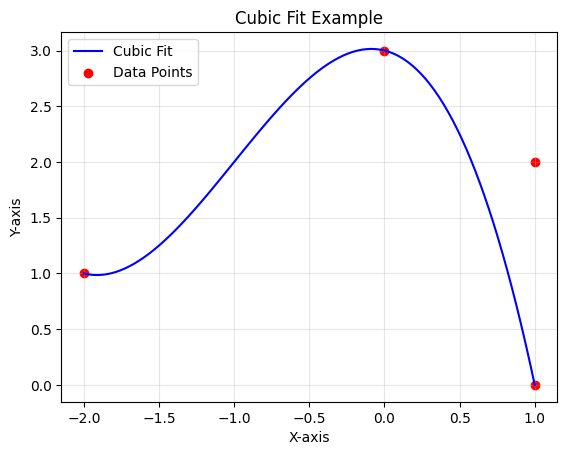

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x = [-2, 1, 0, 1]
y = [1,2,3,0]

def f(x):
	return -2/3*x**3 - 2*x**2 - 1/3 * x + 3

xcont = np.linspace(-2, 1, 100)

plt.plot(xcont, f(xcont), label='Cubic Fit', color='blue')
plt.scatter(x, y, color='red', label='Data Points')
plt.title('Cubic Fit Example')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


3.0


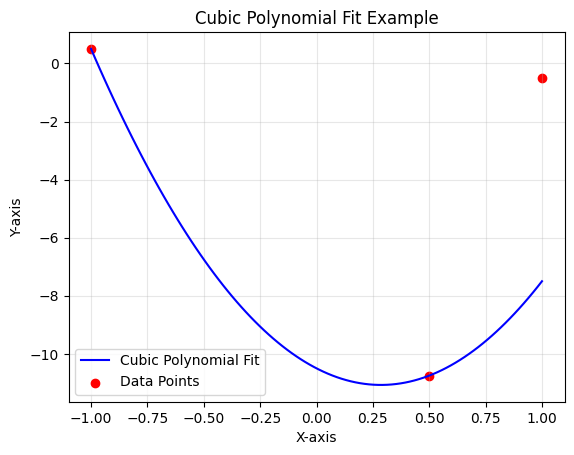

In [4]:
a = -43/4
x = [-1, 1/2, 1]
y = [1/2, a, -1/2]

def p(x):
	return 1/2 + (2*a-1)/3 * x + (2*a-1)/3 + (-1-4*a)/6 * x**2 + (-1-4*a)/12 * x + (1+4*a)/12

# derivative of p using sympy
def dp(x):
	return (2*a-1)/3 + (-1-4*a)/3 * x + (-1-4*a)/12

print(dp(1/2))

xcont = np.linspace(-1, 1, 100)

plt.plot(xcont, p(xcont), label='Cubic Polynomial Fit', color='blue')
plt.scatter(x, y, color='red', label='Data Points')
plt.title('Cubic Polynomial Fit Example')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(alpha=0.3)
plt.show()